# Equivalence between RBM with Gaussian hidden units and BM
RBM with Gaussian hidden units are equivalent to BM with a coupling matrix of rank n_h. Here we define the transformation

In [2]:
import sys
sys.path.append('../source/')
sys.path.append('../utilities/')
import numpy as np
import bm,rbm,utilities
from float_precision import curr_float,curr_int
import matplotlib.pyplot as plt
%matplotlib notebook

../source/numba_utilities.py:14: NumbaWarning: Cannot cache compiled function "dot_Potts_C" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  @njit(signature, parallel=True, cache=True, nogil=False)
../source/numba_utilities.py:32: NumbaWarning: Cannot cache compiled function "dot_Potts2_C" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  @njit(signature, parallel=True, cache=True, nogil=False)
../source/numba_utilities.py:50: NumbaWarning: Cannot cache compiled function "dot_Potts3_C" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  @njit(signature, parallel=True, cache=True, nogil=False)
../source/numba_utilities.py:91: NumbaWarning: Cannot cache compiled function "compute_output_C" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  @njit(signature, parallel=True, cache=True, nogil=False)
../source/numba_utilities.py:113: NumbaWarning: Cannot cache compiled function "c

# Equivalence between RBM with Gaussian hidden units and BM

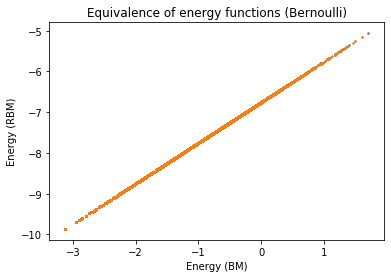

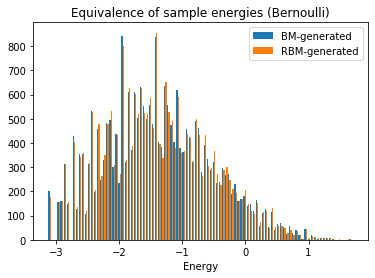

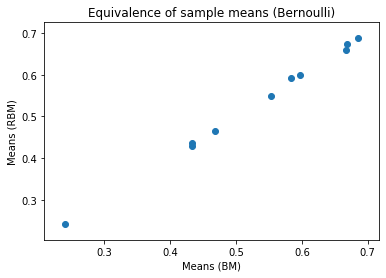

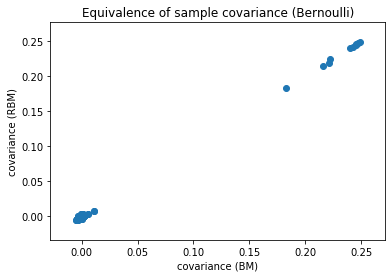

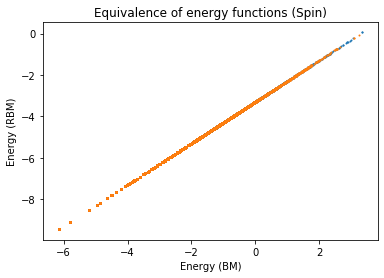

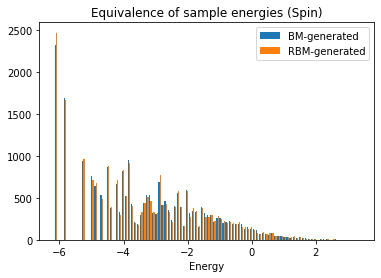

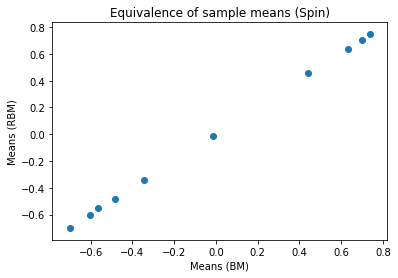

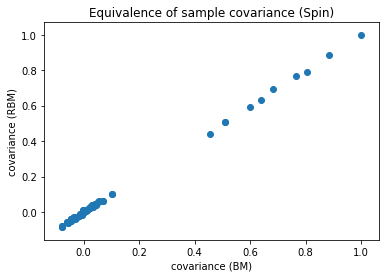

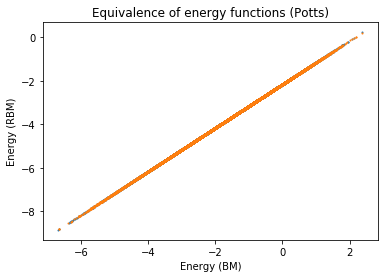

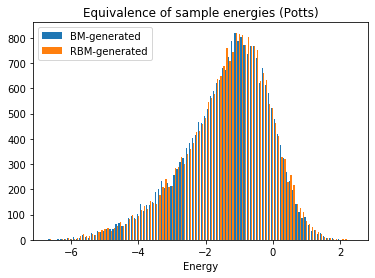

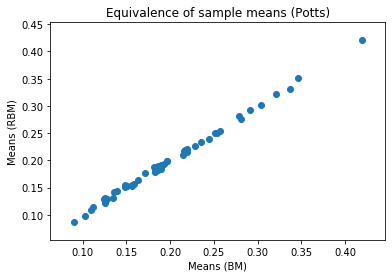

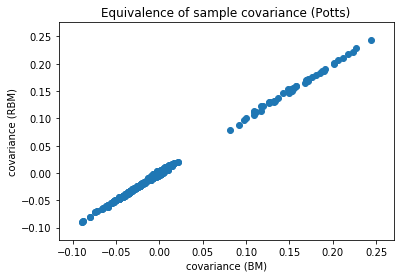

In [4]:
def convert_GaussianRBM_to_BM(RBM):
    assert RBM.hidden == 'Gaussian'
    N = RBM.n_v
    nature = RBM.visible
    n_c = RBM.n_cv
    BM = bm.BM(N=N,nature=nature,n_c=n_c)
    
    if not nature in ['Bernoulli','Spin','Potts']:
        print('Boltzmann Machine %s not supported'%nature)
        return
    
    if nature == 'Bernoulli':
        couplings_BM = np.dot(RBM.weights.T, 1.0/RBM.hlayer.gamma[:,np.newaxis] *  RBM.weights)        
        fields_BM = RBM.vlayer.fields - np.dot(RBM.hlayer.theta/RBM.hlayer.gamma,RBM.weights)    + 0.5 * couplings_BM[np.arange(N),np.arange(N)]
        couplings_BM[np.arange(N),np.arange(N)] *= 0 # Important: Must have zero diagonal.
    elif nature == 'Spin':
        couplings_BM = np.dot(RBM.weights.T,1.0/RBM.hlayer.gamma[:,np.newaxis] * RBM.weights)        
        couplings_BM[np.arange(N),np.arange(N)] *= 0 # Important: Must have zero diagonal.        
        fields_BM = RBM.vlayer.fields - np.dot(RBM.hlayer.theta/RBM.hlayer.gamma,RBM.weights)
    elif nature == 'Potts':
        couplings_BM = (1.0/RBM.hlayer.gamma[:,np.newaxis,np.newaxis,np.newaxis,np.newaxis] *  RBM.weights[:,np.newaxis,:,np.newaxis,:] * RBM.weights[:,:,np.newaxis,:,np.newaxis]).sum(0)
        fields_BM = RBM.vlayer.fields - np.tensordot(RBM.hlayer.theta/RBM.hlayer.gamma,RBM.weights,axes=[(0),(0)]) + 0.5 * couplings_BM[np.arange(N),np.arange(N)][:,np.arange(n_c),np.arange(n_c)]
        couplings_BM[np.arange(N),np.arange(N)] *= 0 # Important: Must have zero diagonal.
    
    
    BM.layer.fields = fields_BM
    BM.layer.fields0 = RBM.vlayer.fields0
    BM.layer.couplings = couplings_BM
    return BM


N = 10 # Number of visible units.
n_h = 2 # Number of hidden units.
beta = 0.25

for nature in ['Bernoulli', 'Spin', 'Potts']:
    if nature == 'Potts':
        n_c = 5 # Number of Potts states.
    else:
        n_c = 1



    if nature == 'Potts':
        fields = beta * np.random.randn(N,n_c).astype(curr_float)
        weights = np.sqrt(beta/N) * np.random.randn(n_h,N,n_c).astype(curr_float)
    else:
        fields = beta * np.random.randn(N).astype(curr_float)
        weights = np.sqrt(beta/N) * np.random.randn(n_h,N).astype(curr_float)    

    RBM = rbm.RBM(n_v=N,n_h=n_h,visible=nature,hidden='Gaussian',n_cv=n_c)
    RBM.vlayer.fields = fields
    RBM.hlayer.gamma = 0.25 + 0.75*np.random.rand(n_h).astype(curr_float)
    RBM.hlayer.theta = np.random.randn(n_h).astype(curr_float)
    RBM.weights = weights

    BM = convert_GaussianRBM_to_BM(RBM)


    configs = BM.gen_data(Nchains=5,Lchains=5000,Nstep=10,Nthermalize=500)
    configs2,_ = RBM.gen_data(Nchains=5,Lchains=5000,Nstep=10,Nthermalize=500)
    
    mu = utilities.average(configs,c=n_c)
    mu2 = utilities.average(configs2,c=n_c)
    
    cov = utilities.covariance(configs,configs,c1=n_c,c2=n_c)
    cov2 = utilities.covariance(configs2,configs2,c1=n_c,c2=n_c)
    


    E11 = BM.energy(configs)
    E12 = RBM.free_energy(configs)

    E21 = BM.energy(configs2)
    E22 = RBM.free_energy(configs2)

    fig, ax = plt.subplots()
    plt.scatter(E11,E12,s=1); plt.scatter(E21,E22,s=1); 
    plt.xlabel('Energy (BM)')
    plt.ylabel('Energy (RBM)')    
    plt.title('Equivalence of energy functions (%s)'%nature)
    plt.show();
    
    fig, ax = plt.subplots()
    plt.hist([E11,E21],bins=100);
    plt.xlabel('Energy')
    plt.legend(['BM-generated','RBM-generated'])
    plt.title('Equivalence of sample energies (%s)'%nature)
    plt.show()


    fig, ax = plt.subplots()    
    plt.scatter(mu,mu2);
    plt.xlabel('Means (BM)')
    plt.ylabel('Means (RBM)')
    plt.title('Equivalence of sample means (%s)'%nature)
    plt.show()


    fig, ax = plt.subplots()    
    plt.scatter(cov,cov2);
    plt.xlabel('covariance (BM)')
    plt.ylabel('covariance (RBM)')
    plt.title('Equivalence of sample covariance (%s)'%nature)
    plt.show()    